In [1]:
#!/usr/bin/env python
__author__      = "Robert Zivkovic"

## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
#set plt style to xkcd
plt.xkcd();

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [7]:
df.query("converted == 1").user_id.nunique()/df.shape[0]

0.1194418598333322

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
df.query("(group == 'control' and landing_page == 'new_page')or(group == 'treatment' and landing_page == 'old_page')").count()[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = df.query("(group == 'control' and landing_page == 'old_page') or (group == 'treatment' and landing_page == 'new_page')")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

solution inspired by the [link](https://thispointer.com/pandas-find-duplicate-rows-in-a-dataframe-based-on-all-or-selected-columns-using-dataframe-duplicated-in-python/)

In [13]:
df2['user_id'].duplicated().sum()

1

In [14]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2['user_id'].duplicated(keep=False)].index[0]

1899

In [16]:
df2[df2['user_id'].duplicated(keep=False)].index[1]

2893

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [17]:
df2.shape

(290585, 5)

In [18]:
df2.drop_duplicates(['user_id'], keep='first', inplace=True)

/Users/hogan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
(df2.query("converted == 1").count()/df2.shape[0])[0]

0.11959708724499628

In [21]:
#df2.converted.mean()

b. Given that an individual was in the `control` group, what is the probability they converted?

In [22]:
c = (df2.query("group == 'control'")['converted']).mean()
c

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [23]:
t = (df2.query("group == 'treatment'")['converted']).mean()
t

0.11880806551510564

d. What is the probability that an individual received the new page?

In [24]:
df2.query("landing_page == 'new_page'").count()[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

__Answer:__

- the control group has a conversion rate of 0.1204
- the treatment group has a conversion rate of 0.1188
- the probability that an individual receives the new page is 0.5
- given the facts that there is an equal chance that an user receives the old page vs the new page is the basically the same and in addition the conversation rates are almost the same (round 2 decimal value is the same). Based on the analysed metrics we cannot confidently say that the new page or the old page leads to more conversions. 

In [25]:
print("control_cr:","%.2f" % round(c,2))
print("treatment_cr:","%.2f" % round(t,2))

control_cr: 0.12
treatment_cr: 0.12


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

*Null Hypothesis*: $H_0: P_{new} \leq P_{old}$


*Alternative Hypothesis*: $H_1: P_{new} > P_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [26]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [27]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [28]:
# the same
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [29]:
n_new = (df2.query("landing_page == 'new_page'")).shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [30]:
n_old = (df2.query("landing_page == 'old_page'")).shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted = np.random.binomial(1, p_new, n_new) 
new_page_converted.mean()

0.11914527561764504

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.binomial(1, p_old, n_old)
old_page_converted.mean()

0.11854839819926484

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
new_page_converted.mean() - old_page_converted.mean()

0.0005968774183802011

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new) 
    old_page_converted = np.random.binomial(1,p_old,n_old) 
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

In [34]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

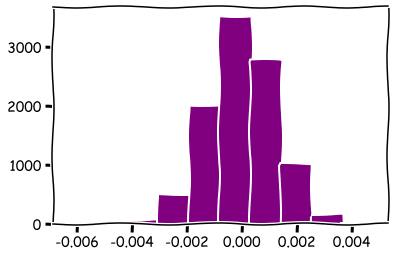

In [35]:
# convert diffs to np array
p_diffs = np.array(p_diffs)

# plot diffs
plt.hist(p_diffs, color='purple');
#plt.grid(color='purple',linewidth=0.5, alpha=.5);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
df2.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted'], dtype='object')

In [37]:
treat_converted = df2.query("group == 'treatment'")['converted'].mean()
control_converted = df2.query("group == 'control'")['converted'].mean()

obs_diff = treat_converted - control_converted
(p_diffs > obs_diff).mean()

0.9095

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

__Answer:__
- A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. A large p-value (> 0.05) indicates weak evidence against the null hypothesis, so you fail to reject the null hypothesis.
- here the p-value is 0.9, therefore it fails to reject the null hypothesis and keep the old page

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm

convert_old = (df2.query("landing_page == 'old_page'")['converted']).sum()
convert_new = (df2.query("landing_page == 'new_page'")['converted']).sum()
n_old = (df2.query("group == 'control'")).shape[0]
n_new = (df2.query("group == 'treatment'")).shape[0];

In [39]:
print("convert old:",convert_old)
print("convert new:",convert_new)
print("n old:",n_old)
print("n new:",n_new)

convert old: 17489
convert new: 17264
n old: 145274
n new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [40]:
count = (convert_old, convert_new)
nobs = (n_old,n_new)

In [41]:
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

__Answer:__
- z_score of 1.311 tells us that the z_score is 1.311 std above the mean. On the bell curve our data point for the z-score is on the right side of the mean line.
- the calculated p-value of 0.905 is almost the same as the result we computed in j. that supports the fail to reject the null hypothesis decision. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

__Answer:__
- logistic regression
- predict only two possible outcomes

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
# create a copy of the df2
df_log = df2.copy()
df_log['intercept'] = 1
df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [43]:
# create dummy variables
#df_log[['new_page','old_page']] = pd.get_dummies(df_log['landing_page'])
df_log[['control_group','ab_page']] = pd.get_dummies(df_log['group'])

df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,control_group,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [44]:
# drop treat_group and new_page columns
#df_log = df_log.drop(['old_page','control_group', ],axis=1)
df_log = df_log.drop(['control_group', ],axis=1)
df_log.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [45]:
print(df_log['converted'].mean())
print(df_log['ab_page'].mean())

0.11959708724499628
0.5000619442226688


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [46]:
# create model
logit_mod = sm.Logit(df_log['converted'], df_log[['intercept','ab_page']])
# fit model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:               8.077e-06
Time:                        23:09:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [48]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [49]:
1/_

intercept    7.306593
ab_page      1.015102
dtype: float64

In [50]:
# get p-value as if it were a one-tailed 
1 - (0.190/2)

0.905

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

__Answer:__
- the p-value for the ab_page is 0.19 which suggests this is not statistically significant (p-values which are less than 0.05 suggest statistical significance)
- reason for difference in PartII is thate we performed a two-sided test that implies p_new = p_old

- $H_0: p_{new} = p_{old}$
- $H_1: p_{new} \ne p_{old}$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

__Answer:__
- additional factors to be taken into account would be a good idea. E.g. action - if a user just viewed or actually clicked on the page (click through rate), duration of the session, etc. 
- after computation, the additional features can be tested for significance and potentially they can help to obtain more precise decisions.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [51]:
# import country data
country_df = pd.read_csv("./countries.csv")
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [52]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [53]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
dtypes: int64(3), object(3), uint8(1)
memory usage: 15.8+ MB


In [54]:
# merge data on the user_id with df_log
new_df = pd.merge(country_df, df_log, how='left', left_on='user_id',right_on='user_id')
new_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [55]:
# create dummy variables for countries
new_df.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [56]:
new_df[['CA','UK','US']] = pd.get_dummies(new_df['country'])
#new_df.drop('US', axis=1, inplace=True)

In [57]:
new_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [58]:
# create and fit new model
new_df['intercept'] = 1

logit_mod = sm.Logit(new_df['converted'], new_df[['intercept', 'CA','UK']])
#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:               1.521e-05
Time:                        23:09:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

__Remember if the p-values are less than 0.05, this suggests there is a statistically significant relationship between the variable and the response variable.__

In [60]:
# 1. exponentiate each
np.exp(results.params)

intercept    0.135779
CA           0.960018
UK           1.009966
dtype: float64

In [61]:
#np.exp(-0.0408)

In [62]:
#np.exp(0.0099)

In [63]:
1/_

intercept    7.364925
CA           1.041647
UK           0.990133
dtype: float64

__Answer:__
- By looking at the the countries columns have p-values higher than 0.05. This suggests that that they are not statistically significant. 
- users from UK are 1.01 times more likely to convert as users from US
- users from CA are 0.96 times more likely to convert as users from US

In [64]:
new_df.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [65]:
# logit_g = sm. Logit (df_final['converted'], df_final[['intercept', 'ab_page', 'CA', 'UK']])

In [66]:
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
logit_h = sm.Logit(joined_data['converted'], joined_data[['intercept', 'ab_page', 'US', 'CA', 'US_ind_ab_page', 'CA_ind_ab_page']])

NameError: name 'joined_data' is not defined

In [67]:
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
model = sm.Logit(new_df.converted, new_df[['UK', 'US','UK_ab_page','US_ab_page','ab_page']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.374250
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 12 Sep 2019   Pseudo R-squ.:                -0.02220
Time:                        23:26:12   Log-Likelihood:            -1.0875e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
UK            -1.9922      0.016   -123.457      0.000      -2.024      -1.961
US            -1.9865      0.010   -206.344      0.000      -2.005      -1.968
UK_ab_page     2.0823      0.044     47.787      0.000       1.997       2.168
US_ab_page     2.0509      0.040     51.845      0.000       1.973       2.128
ab_page       -2.0715      0.037    -55.798      0.000      -2.144      -1.999
==============================================================================
"""

In [ ]:
new_df.head()

In [ ]:
## Conclusion

- 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

### Helper Links

- [print two decimals](https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points)
- [p-value](https://www.dummies.com/education/math/statistics/what-a-p-value-tells-you-about-statistical-data/)
- [z-score](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/z-score/)
- [merge_df](https://michaeljsanders.com/2017/04/17/python-vlookup.html)

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])